In [2]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from datetime import timedelta
import tqdm
import h3

In [4]:
records = pd.read_pickle('output/_waze_temp/waze_12_features.pkl')
labels = pd.read_pickle('output/_waze_temp/waze_12_labels.pkl')

In [5]:
records.head()

,time,reliability,r_86264d8dfffffff,r_86264d157ffffff,r_86264d177ffffff,r_86264d10fffffff,r_86264d11fffffff,r_86264d107ffffff,r_86264d117ffffff,r_86264d137ffffff,...,r_86264d887ffffff,r_86264d897ffffff,r_86264d147ffffff,r_86264d8a7ffffff,r_86264d8c7ffffff,r_86264d187ffffff,r_86264d1a7ffffff,r_86264dc67ffffff,r_86264dc77ffffff,r_86264dd5fffffff
0,2019-12-03 02:41:41,7,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-12-03 14:49:24,5,0.0,0.072373,0.382160,0.545467,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-12-03 14:46:04,10,0.0,0.000000,0.000000,0.152059,0.808363,0.039578,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-12-03 14:38:57,5,0.0,0.115842,0.401464,0.482694,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-12-03 14:34:57,10,0.0,0.012711,0.324826,0.662463,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
np.unique(records.reliability, return_counts=True)

(array([ 5,  6,  7,  8,  9, 10]), array([1447, 1038,  782,  603,  509, 1782]))

In [7]:
labels.loc[:, 'region'] = labels.hex6.apply(lambda x: 'r_' + x)

### Incident Time Intervel

- Definition: The average time taken for the arrival of first waze repot to the last waze report

In [8]:
labels.head()

,segment_id,time,lat,lng,timestamp,count,hex6,region
8,75,2019-12-19 16:06:00,36.33891,-86.91617,1.576772e+09,1,86264dc77ffffff,r_86264dc77ffffff
9,75,2019-12-08 20:18:00,36.33207,-86.90093,1.575836e+09,1,86264dd5fffffff,r_86264dd5fffffff
10,75,2019-12-08 22:45:00,36.33152,-86.90128,1.575845e+09,1,86264dd5fffffff,r_86264dd5fffffff
11,75,2019-12-09 13:04:00,36.33891,-86.91617,1.575897e+09,1,86264dc77ffffff,r_86264dc77ffffff
34,78,2019-12-15 20:01:00,36.32500,-86.87300,1.576440e+09,1,86264dc67ffffff,r_86264dc67ffffff


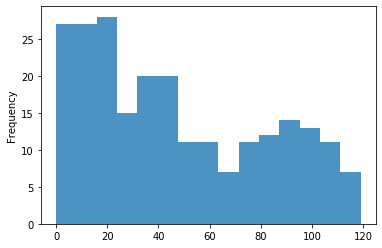

In [9]:
# calculate the time difference between two consecative incidents in same region
consec_inc_td = []

for region in labels.hex6.unique():
    time = labels[labels.hex6 == region].sort_values('time').time.diff().dropna().astype('timedelta64[m]')
    consec_inc_td += time[time.notnull()].tolist()
    
consec_inc_td_df = pd.Series(consec_inc_td).sort_values()

consec_inc_td_df[consec_inc_td_df < 120].plot.hist(bins=15, alpha=0.8)

In [50]:
# T' calculation

number_of_reports = []

pre_dt = timedelta(minutes=30)

for region in labels.hex6.unique():
    region_df = labels[labels.hex6 == region]
    col = 'r_' + region
    if col in records:
        records_after = records.loc[records[col] > 0, ['time', 'reliability', col]]
        for incident_time in region_df.time.sort_values():
            records_before = records_after[((incident_time - pre_dt) <= records_after.time) & (records_after.time <= incident_time)]
            time_intervels = (incident_time - records_before.sort_values('time').time).astype('timedelta64[m]')
            if len(time_intervels) != 0:
                number_of_reports += time_intervels.tolist()
            else:
                number_of_reports += [35]
            records_after = records_after[records_after.time > incident_time]
            
number_of_reports_df = pd.DataFrame(number_of_reports)

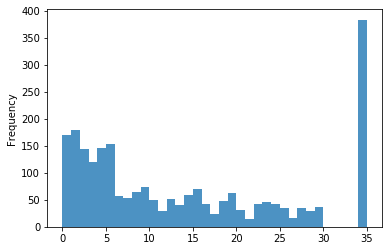

In [51]:
number_of_reports_df = pd.Series(number_of_reports).sort_values()

number_of_reports_df.plot.hist(bins=35, alpha=0.8, label='Time')

In [12]:
labels

,segment_id,time,lat,lng,timestamp,count,hex6,region
8,75,2019-12-19 16:06:00,36.33891,-86.91617,1.576772e+09,1,86264dc77ffffff,r_86264dc77ffffff
9,75,2019-12-08 20:18:00,36.33207,-86.90093,1.575836e+09,1,86264dd5fffffff,r_86264dd5fffffff
10,75,2019-12-08 22:45:00,36.33152,-86.90128,1.575845e+09,1,86264dd5fffffff,r_86264dd5fffffff
11,75,2019-12-09 13:04:00,36.33891,-86.91617,1.575897e+09,1,86264dc77ffffff,r_86264dc77ffffff
34,78,2019-12-15 20:01:00,36.32500,-86.87300,1.576440e+09,1,86264dc67ffffff,r_86264dc67ffffff
...,...,...,...,...,...,...,...,...
6921,2922,2019-12-30 14:00:00,36.12500,-86.73495,1.577714e+09,1,86264d10fffffff,r_86264d10fffffff
6922,2922,2019-12-04 16:47:00,36.12430,-86.74385,1.575478e+09,1,86264d10fffffff,r_86264d10fffffff
6923,2922,2019-12-04 19:15:00,36.12435,-86.74214,1.575487e+09,1,86264d10fffffff,r_86264d10fffffff
6924,2922,2019-12-09 23:27:00,36.12434,-86.74273,1.575934e+09,1,86264d10fffffff,r_86264d10fffffff


### Estimate posterior probabilities every 5 min (keep doing this up to T' min)

In [44]:
def h3_get_neighbors(region):
    if region.startswith('r_'):
        region = region[2:]
    return [x for x in np.unique(labels.region) if h3.h3_indexes_are_neighbors(region, x[2:])]
        
h3_get_neighbors('86264d10fffffff')

['r_86264d027ffffff',
 'r_86264d107ffffff',
 'r_86264d11fffffff',
 'r_86264d12fffffff',
 'r_86264d157ffffff',
 'r_86264d177ffffff']

In [45]:
# change to historical data values
# P(I=1,R1)
def region_prior(region, time):
    # use labels_prv to prevent overfitting
    # return 1 / len(np.unique(labels.region))
    # return np.sum((labels.region == region) & (time.hour == labels.time.dt.hour)) / len(labels)
    return np.sum(labels.region == region) / len(labels)
    
# np.sum([region_prior(r, 0) for r in np.unique(labels.region)])

In [46]:
def p(r):
    return r / 10

In [47]:
def calculate_likelihood(m):
    c = m.reliability.apply(p)
    m.drop('reliability', axis=1, inplace=True)
    if m.shape[0] == 0:
        m.loc[0], c = np.zeros(m.shape[1]), 0
    return (m.T * c).T.prod(axis=0)

In [48]:
def calculate_posterior(df, r, time_step=5):
    time_steps_records = df.set_index('time').resample(f'{time_step}T')
    # Matrix - containes total likelihood
    matrix = time_steps_records.apply(calculate_likelihood)
    # Find likelihood, prior for first time period
    likelihood = matrix.iloc[0, :]
    prior = np.array([region_prior(c, matrix.index[0]) for c in matrix])
    # Calcualate prior for I = 0 for first time period
    p_0 = (1 - np.sum(prior))
    # Calcualate likelihood for I = 0 for all periods using reliability of waze reports prod(1-p)
    l_0 = time_steps_records.apply(lambda m: (1 - m.reliability.apply(p)).prod())
    denom = np.sum(likelihood * prior) + l_0[0] * p_0
    # For each time step calculate posterior (start with zero row - special case) 
    # matrix - containes posteriors [partly]   
    matrix.iloc[0, :] = likelihood * prior / denom
    p_0 = l_0[0] * p_0 / denom
    return_row = [True for _ in range(matrix.shape[0])]
    for ridx in range(1, matrix.shape[0]):
        prior = matrix.iloc[ridx - 1, :]
        likelihood = matrix.iloc[ridx, :]
        if np.sum(likelihood) == 0:
            matrix.iloc[ridx, :] = prior
            return_row[ridx] = False
            continue
        # Calculate denominator of posterior
        denom = np.sum(likelihood * prior) + l_0[ridx] * p_0
        # Calculate posterior
        matrix.iloc[ridx, :] = likelihood * prior / denom
        p_0 = l_0[ridx] * p_0 / denom
    # Return posteriors
    return matrix[return_row].index, matrix[return_row].loc[:, r]

In [84]:
def incident_posterior(df, incident_interval=25):
    incident_interval = timedelta(minutes=incident_interval)
    features = []
    incident_id = 0
    for col in tqdm.tqdm(df.columns):
        # for each region
        if col.startswith('r_'):
            surrounding_regions = ['time', 'reliability', col] + [x for x in h3_get_neighbors(col) if x in df.columns]
            df_region = df.loc[df[col] > 0, surrounding_regions]
            incident_time = np.min(df_region.time)
            while incident_time <= np.max(df_region.time):
                incident_records = df_region[(incident_time <= df_region.time) & (df_region.time < (incident_time + incident_interval))]
                time_steps, posterior_probs = calculate_posterior(incident_records, col)
                features_temp = []
                for time_step, posterior_proba in zip(time_steps, posterior_probs):
                    features_temp.append({
                        'incident_id': incident_id, 
                        'start_time': incident_time,
                        'end_time': incident_time + incident_interval,
                        'time': time_step, 
                        'region': col,
                        'posterior_proba': posterior_proba,
                    })
                features += features_temp
                incident_time = np.min(df_region[(incident_time + incident_interval) <= df_region.time].time)
                incident_id = incident_id + 1
    return pd.DataFrame(features)

features = incident_posterior(records)

features.head()

 19%|█▉        | 5/26 [00:10<00:43,  2.07s/it]


SystemError: <built-in function is_scalar> returned a result with an error set

In [73]:
# number of incidents with the number of waze reports

pd.DataFrame(np.unique(features.groupby('incident_id').size(), return_counts=True))

,0,1,2,3,4
0,1,2,3,4,5
1,1113,417,144,34,6


In [74]:
np.unique(features.incident_id).size

1714

# Incident Prediction

In [75]:
# Map labels with records
def label_mapper(features, labels):
    mapped_labels = []
    for index, row in features.iterrows():
        label = labels[(labels.time >= row.start_time) & (labels.time < row.end_time) & (labels.region==row.region)]
        mapped_labels.append(label.shape[0] > 0)
    return mapped_labels

In [76]:
features.loc[:,'label'] = label_mapper(features, labels)

In [77]:
features = features.dropna()

features.head()

,incident_id,start_time,end_time,time,region,posterior_proba,label
0,0,2019-12-01 01:35:57,2019-12-01 02:00:57,2019-12-01 01:35:00,r_86264d8dfffffff,0.025879,False
1,1,2019-12-02 12:26:36,2019-12-02 12:51:36,2019-12-02 12:25:00,r_86264d8dfffffff,1.000000,False
2,2,2019-12-02 21:43:14,2019-12-02 22:08:14,2019-12-02 21:40:00,r_86264d8dfffffff,0.003156,False
3,2,2019-12-02 21:43:14,2019-12-02 22:08:14,2019-12-02 21:45:00,r_86264d8dfffffff,0.453619,False
4,2,2019-12-02 21:43:14,2019-12-02 22:08:14,2019-12-02 22:00:00,r_86264d8dfffffff,0.039441,False


In [78]:
np.unique(features.label, return_counts=True)

(array([False,  True]), array([2039,  506]))

In [79]:
np.unique(features[features.posterior_proba> 0.6].label, return_counts=True)

(array([False,  True]), array([660, 350]))

In [80]:
features.loc[:, 'hour'] = features.time.dt.hour

features.loc[:, 'is_peak'] = ((1 <= features.hour) & (features.hour <= 4)) | ((10 <= features.hour) & (features.hour <= 14))

features.loc[:, 'rand'] = np.random.rand(features.shape[0])

features.head()

,incident_id,start_time,end_time,time,region,posterior_proba,label,hour,is_peak,rand
0,0,2019-12-01 01:35:57,2019-12-01 02:00:57,2019-12-01 01:35:00,r_86264d8dfffffff,0.025879,False,1,True,0.555270
1,1,2019-12-02 12:26:36,2019-12-02 12:51:36,2019-12-02 12:25:00,r_86264d8dfffffff,1.000000,False,12,True,0.175682
2,2,2019-12-02 21:43:14,2019-12-02 22:08:14,2019-12-02 21:40:00,r_86264d8dfffffff,0.003156,False,21,False,0.330542
3,2,2019-12-02 21:43:14,2019-12-02 22:08:14,2019-12-02 21:45:00,r_86264d8dfffffff,0.453619,False,21,False,0.150127
4,2,2019-12-02 21:43:14,2019-12-02 22:08:14,2019-12-02 22:00:00,r_86264d8dfffffff,0.039441,False,22,False,0.973796


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

feature_extractor = ColumnTransformer([
    ('posterior_proba', 'passthrough', ['posterior_proba']),
    # ('is_peak', 'passthrough', ['is_peak']),
#     ('hour_enc', OneHotEncoder(), ['hour']),
#     ('region_enc', OneHotEncoder(), ['region']),
])

X = feature_extractor.fit_transform(features)
y = features.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train, y_train)

y_pred = reg.predict(X_test)

# cross validate

reg.score(X_test, y_test)

0.6844583987441131

In [82]:
-reg.intercept_ / reg.coef_

array([[0.55740994]])

In [83]:
from sklearn.metrics import classification_report

# Random Probability Baseline

#               precision    recall  f1-score   support

#        False       0.80      0.51      0.62       698
#         True       0.18      0.47      0.26       166

#     accuracy                           0.50       864
#    macro avg       0.49      0.49      0.44       864
# weighted avg       0.68      0.50      0.55       864

# ---------------------------------------------------------

# Probability calulation using proposed method

# -- With equal distribution of region priors 

#               precision    recall  f1-score   support

#        False       0.85      0.91      0.88       698
#         True       0.47      0.34      0.40       166

#     accuracy                           0.80       864
#    macro avg       0.66      0.63      0.64       864
# weighted avg       0.78      0.80      0.79       864

# -- With calculated distribution of region priors based on region labels

#               precision    recall  f1-score   support

#        False       0.86      0.88      0.87       698
#         True       0.43      0.37      0.40       166

#     accuracy                           0.78       864
#    macro avg       0.64      0.63      0.63       864
# weighted avg       0.77      0.78      0.78       864

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.69      0.78       518
        True       0.33      0.66      0.44       119

    accuracy                           0.68       637
   macro avg       0.61      0.67      0.61       637
weighted avg       0.79      0.68      0.72       637



In [426]:
import scipy
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [427]:
def thr_to_f1_score(thr, Y_test, predictions):
   return -f1_score(Y_test, np.array(predictions > thr, dtype=np.int))

best_thr = scipy.optimize.fmin(thr_to_f1_score, args=(features['label'].values, features['posterior_proba'].values), x0=0.5, maxiter=100)

print(best_thr)

print(classification_report(features['label'].values, features['posterior_proba'].values > best_thr))

Optimization terminated successfully.
         Current function value: -0.405858
         Iterations: 10
         Function evaluations: 27
[0.55]
              precision    recall  f1-score   support

       False       0.90      0.50      0.64      2039
        True       0.28      0.77      0.41       506

    accuracy                           0.55      2545
   macro avg       0.59      0.63      0.52      2545
weighted avg       0.77      0.55      0.60      2545



In [428]:
def thr_to_precision_score(thr, Y_test, predictions):
    return -precision_score(Y_test, np.array(predictions > thr, dtype=np.int))

best_thr = scipy.optimize.fmin(thr_to_precision_score, args=(features['label'].values, features['posterior_proba'].values), x0=0.5, maxiter=100)

print(best_thr)

print(classification_report(features['label'].values, features['posterior_proba'].values > best_thr))

Optimization terminated successfully.
         Current function value: -0.275960
         Iterations: 10
         Function evaluations: 27
[0.55]
              precision    recall  f1-score   support

       False       0.90      0.50      0.64      2039
        True       0.28      0.77      0.41       506

    accuracy                           0.55      2545
   macro avg       0.59      0.63      0.52      2545
weighted avg       0.77      0.55      0.60      2545



In [429]:
def thr_to_recall_score(thr, Y_test, predictions):
    return -recall_score(Y_test, np.array(predictions > thr, dtype=np.int))

best_thr = scipy.optimize.fmin(thr_to_recall_score, args=(features['label'].values, features['posterior_proba'].values), x0=0.5, maxiter=100)

print(best_thr)

print(classification_report(features['label'].values, features['posterior_proba'].values > best_thr))

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 16
         Function evaluations: 42
[-0.05]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      2039
        True       0.20      1.00      0.33       506

    accuracy                           0.20      2545
   macro avg       0.10      0.50      0.17      2545
weighted avg       0.04      0.20      0.07      2545



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [430]:
def thr_to_accuracy_score(thr, Y_test, predictions):
    return -accuracy_score(Y_test, np.array(predictions > thr, dtype=np.int))

best_thr = scipy.optimize.fmin(thr_to_accuracy_score, args=(features['label'].values, features['posterior_proba'].values), x0=0.5, maxiter=100)

print(classification_report(features['label'].values, features['posterior_proba'].values > best_thr))

Optimization terminated successfully.
         Current function value: -0.553635
         Iterations: 10
         Function evaluations: 27
              precision    recall  f1-score   support

       False       0.90      0.50      0.64      2039
        True       0.28      0.77      0.41       506

    accuracy                           0.55      2545
   macro avg       0.59      0.63      0.52      2545
weighted avg       0.77      0.55      0.60      2545

